# Algoritmo evolutivo para otimização de função
Desenvolvimento de um Algoritmo Evolucionário (Estratégia Evolutiva) para a determinação do ponto de mínimo global da função de Ackley
Grupo : 
 - Alexandra Zarzar (avz)
 - Luana Porciuncula (lpb)
 - Victor Hugo Kunst (vhlk)

### Descrição esquemática do algoritmo implementado
![Descrição esquemática](https://raw.githubusercontent.com/vhlk/EEAckleyFunc/main/descricao_esquematica.png?token=GHSAT0AAAAAABYT2KLRFM3TLIEAPMPU37OGYZCPP5A)


### Descrição dos processos de:
#### a. Representação das soluções (indivíduos)
Cada individuo da solução será uma lista de tamanho D (neste caso, D=30), onde cada elemento é no máximo 15 e no mínimo -15 (para ackley, já para a função de schwefel, seguimos o range recomendado no site de (-500, 500))
#### b. Função de Fitness
A propria função de otimização (ackley ou schwefel). Quanto menor o valor, melhor o fitness.
#### c. População (tamanho, inicialização, etc)
Utilizamos uma população de tamanho 30. 
A população é inicializada com valores aleatórios do entre o range de Xi (-15, 15 ou -500, 500).
Para criar pressão de seleção, geramos uma quantidade de filhos 7 vezes o tamanho da população (210).
#### d. Processo de seleção de pais
2 pais são selecionados de forma uniforme e aleatória para cada recombinação.
#### e. Operadores Genéticos (Recombinação e Mutação)
São selecionados 210 (quantidade de filhos) duplas de pais, e cada um fará uma recombinação para gerar 1 filho.
Para a recombinação, fizemos duas implementações: Local discreta (seleciona aleatoriamente um Xi de cada pai) e Local intermediaria (o Xi do filho é o valor médio entre o Xi dos dois pais). 

Para a mutação, mutamos todos os filhos gerados, seguindo o caso de "Mutação não correlacionada com um σ".
Primeiro geramos um novo σ, com base no σ anterior do individuo => σ' = σ × exp(τ × N(0,1)). Usando a taxa de aprendizagem τ como 1/√(D).
O novo σ, é limitado sendo no minimo um ε0 (EPSILON_0) para evitar passos muito pequenos. E também sendo no máximo um ε1 (EPSILON_1) para evitar passos muito grandes, tendo em vista que o range de xi é limitado (-15,15 e -500,500)
Em seguida, mutacionamos o individuo usando o novo σ => xi + σ' × N(0,1)
Após mutacionar o individuo, comparamos o fitness antigo com o novo fitness do individuo, avaliando quantas mutações foram um "sucesso" (isto é, o fitness novo foi menor que o antigo - Será utilizado para ajustar a mutação por meio do "1/5 da regra de sucesso" após a seleção de sobreviventes).
#### f. Processo de seleção por sobrevivência
Para a seleção de sobreviventes fizemos 2 implementações, uma geracional (geração anterior é descartada, e sobrevivem os melhores filhos da população) e outra elitista (sobrevivem os melhores da população)
#### g. Condições de término do Algoritmo Evolucionário
As condições de termino são: 
 - (Encontrou solução) Se o algoritmo alcançou a solução (se é proximo de 0 numa margem de erro de 0.005)
 - (Número máximo de iterações) Se o algoritmo alcançou o número limite de iterações
 - (Early stopping) Se o algoritmo passou 50 iterações sem melhorar o melhor fitness em 0.0005

##### imports

In [1]:
from numpy import exp
from numpy import sqrt
from numpy import cos, sin
from numpy import e
from numpy import pi
from typing import List, Callable, Tuple
import random
import matplotlib.pyplot as plt
import numpy as np

#### Definindo váriaveis e função de avaliação

In [2]:
A = 20
B = 0.2
C = 2 * pi
D = 30

In [3]:
TAM_DA_POPULACAO = 30
QTD_DE_FILHOS = 7 * TAM_DA_POPULACAO
POPULACAO = []
TAXA_APRENDIZAGEM = 1 / sqrt(D)
EPSILON_0 = 0.001
EPSILON_1 = 10
MAX_ITERS = 10000
NUM_EXEC = 30
LIM_DE_ITER_SEM_MELHORA = 50
CURR_SUCCESS = 0
FITNESS_FUNC = None
CROSSOVER_FUNC = None
SURV_SELECTION_FUNC = None
RANGE_XI = (-15,15)

In [4]:
def ackley_funct(x: List[float]):
  return - A * exp(-B * sqrt(sum(map(lambda n: n ** 2, x)) / D)) \
          - exp(sum(map(lambda n: cos(C * n), x)) / D) \
          + A + exp(1)

In [49]:
def schwefel_funct(x: List[float]):
    return 418.9829 * D - sum(map(lambda n: n * sin(sqrt(abs(n))), x))

In [50]:
def sum_squares_function(x: List[float]):
    soma = 0

    for i in range(D):
        soma += (i+1) * x[i] ** 2

    return soma

In [51]:
FITNESS_FUNC = sum_squares_function

In [5]:
def fitness(fitness_func: Callable, cromossome: List[float]):
    return fitness_func(cromossome)

In [53]:
print(f'{ackley_funct([0 for _ in range(30)]) : .15f}')

 0.000000000000000


# Estratégia Evolutiva

## Inicialização da população

In [54]:
def generate_individual():
  x = []
  for i in range(D):
    x.append(random.uniform(RANGE_XI[0], RANGE_XI[1]))
    
  return x

In [55]:
def generate_population():
  global POPULACAO, TAM_DA_POPULACAO
  
  for _ in range(TAM_DA_POPULACAO):
    POPULACAO.append((generate_individual(), random.normalvariate(0, 1)))

In [56]:
def reset_population() -> None:
    global POPULACAO

    POPULACAO = []

## Seleção de pais

In [57]:
def select_parents():
    global POPULACAO

    pai1, pai2 = random.sample(POPULACAO, 2)

    return pai1, pai2

## Recombinação

In [58]:
def evolutive_crossover(pai1: Tuple[List[float], float], pai2: Tuple[List[float], float]):
    global CROSSOVER_FUNC
    return CROSSOVER_FUNC(pai1, pai2)

In [59]:
def local_intermediary(pai1: Tuple[List[float], float], pai2: Tuple[List[float], float]):
    filho = []
    for i in range(D):
        filho += [(pai1[0][i] + pai2[0][i])/2]
        
    sigma = (pai1[1] + pai2[1])/2

    return filho, sigma

In [60]:
def local_discrete(pai1: Tuple[List[float], float], pai2: Tuple[List[float], float]):
    filho = []
    for i in range(D):
        filho += random.sample([pai1[0][i], pai2[0][i]], 1)
        
    sigma = random.sample([pai1[1], pai2[1]], 1)[0]

    return filho, sigma

In [61]:
CROSSOVER_FUNC = local_intermediary

In [62]:
def crossover():
    global QTD_DE_FILHOS

    filhos = []
    for _ in range(QTD_DE_FILHOS):
        pai1, pai2 = select_parents()
        filhos.append(evolutive_crossover(pai1, pai2))

    return filhos

## Mutação

In [63]:
def regra_1_quinto(sigma: float, sucesso: float) -> float:
    c = 0.8
    
    if sucesso > 1 / 5:
        sigma = sigma / c
    elif sucesso < 1 / 5:
        sigma = sigma * c
    
    return sigma

In [64]:
def calc_sigma(sigma: float) -> float:
    global TAXA_APRENDIZAGEM, EPSILON_0, EPSILON_1

    new_sigma = sigma * exp(TAXA_APRENDIZAGEM * random.normalvariate(0, 1))

    return min(max(new_sigma, EPSILON_0), EPSILON_1)

In [65]:
def test_success(old_indiv_fitness, new_indiv_fitness):
    global CURR_SUCCESS

    if new_indiv_fitness < old_indiv_fitness:
        CURR_SUCCESS += 1

In [66]:
def get_success() -> float:
    global CURR_SUCCESS
    
    return CURR_SUCCESS / QTD_DE_FILHOS

In [67]:
def reset_success() -> None:
    global CURR_SUCCESS

    CURR_SUCCESS = 0

In [68]:
def mutate_and_calc_sucess(individuo: List[float], sigma: float):
    global FITNESS_FUNC
    
    novo_sigma = calc_sigma(sigma)

    old_fitness = fitness(FITNESS_FUNC, individuo)
    
    for i in range(len(individuo)):
        individuo[i] = min(max(individuo[i] + novo_sigma * random.normalvariate(0, 1), RANGE_XI[0]), RANGE_XI[1])

    new_fitness = fitness(FITNESS_FUNC, individuo)
    test_success(old_fitness, new_fitness)

    return individuo, novo_sigma

In [69]:
def mutate(filhos: List[Tuple[List[float], float]]):
    global QTD_DE_FILHOS

    filhos_mutados = []
    for i in range(QTD_DE_FILHOS):
            filhos_mutados.append(mutate_and_calc_sucess(filhos[i][0], filhos[i][1]))

    return filhos_mutados

## Seleção de sobreviventes

#### Geracional

In [70]:
def generational(filhos: List[Tuple[List[float], float]], iteration):
    global POPULACAO, FITNESS_FUNC, TAM_DA_POPULACAO
    reset_population()
    
    filhos.sort(key=lambda filho: fitness(FITNESS_FUNC, filho[0]), reverse=False)
    POPULACAO = filhos[:TAM_DA_POPULACAO]

In [71]:
def elitist(filhos: List[Tuple[List[float], float]], iteration):
    global POPULACAO, FITNESS_FUNC, TAM_DA_POPULACAO
    
    POPULACAO += filhos
    POPULACAO.sort(key=lambda filho: fitness(FITNESS_FUNC, filho[0]), reverse=False)
    POPULACAO = POPULACAO[:TAM_DA_POPULACAO]

In [72]:
SURV_SELECTION_FUNC = generational

## Condição de parada

In [20]:
def is_close(a: float, b: float, diff: float = 0.005):
    if a + diff > b and b + diff > a:
        return True
        
    return False

In [74]:
def should_stop(curr_best_fitness: float, curr_iter: int, iter_sem_melhora: int):
    global MAX_ITERS, LIM_DE_ITER_SEM_MELHORA
    if is_close(curr_best_fitness, 0):
        return True
    if curr_iter == MAX_ITERS:
        return True
    if iter_sem_melhora == LIM_DE_ITER_SEM_MELHORA:
        return True

    return False

## Evolução

In [75]:
def generate_solution():
    global POPULACAO, TAM_DA_POPULACAO, FITNESS_FUNC

    iteration = 0
    best_fitness = float("inf")
    curr_best_fitness = float("inf")
    best_solution = None
    bests_fitness = []
    bests_sigma = []

    iter_sem_melhora = 0

    reset_population()
    generate_population()    

    while (not should_stop(best_fitness, iteration, iter_sem_melhora)):
        reset_success()

        filhos = crossover()    
        filhos = mutate(filhos)

        success = get_success()

        for i in range(len(filhos)):
            filhos[i] = (filhos[i][0], regra_1_quinto(filhos[i][1], success))

        SURV_SELECTION_FUNC(filhos, iteration)        

        if (abs(curr_best_fitness-fitness(FITNESS_FUNC, POPULACAO[0][0]))) > 0.0005:
            iter_sem_melhora = 0
        else: 
            iter_sem_melhora += 1

        curr_best_fitness = fitness(FITNESS_FUNC, POPULACAO[0][0])
        bests_fitness.append(curr_best_fitness)
        bests_sigma.append(POPULACAO[0][1])

        if curr_best_fitness <= best_fitness:
            best_fitness = curr_best_fitness
            best_solution = POPULACAO[0][0]

        iteration += 1

    return best_fitness, best_solution, bests_fitness, bests_sigma, iteration


## Resultados

In [44]:
def plot_results(best_fitness, best_solution, bests_fitness, bests_sigma, iteration) -> None:
    fig = plt.figure(figsize=(12, 6))
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    fig.suptitle('Evolution x iteration')
    
    # Fitness
    ax1.plot(range(0,iteration), bests_fitness)
    ax1.set(xlabel='iteration', ylabel='melhor fitness',ylim = 0,
           title='fitness evolution')
    ax1.grid()

    # Desvio Padrão
    ax2.plot(range(0,iteration), bests_sigma)
    ax2.set(xlabel='iteration', ylabel='melhor desvio padrão',
           title='sigma evolution')
    ax2.grid()

    fig.tight_layout()
    plt.show()

    print(f'{best_fitness:.4f}', [round(sol, 4) for sol in best_solution])

In [78]:
def run_executions():
    num_exec_com_sucesso = 0
    best_result = [float("inf"), None, None, None, None]
    bests_fitness = []
    
    for i in range(NUM_EXEC):
        results = generate_solution()
        bests_fitness.append(results[0])
    
        if is_close(results[0], 0):
            num_exec_com_sucesso += 1

        if best_result[0] > results[0]:
            best_result[0] = results[0] # Melhor fitness da execução
            best_result[1] = results[1] # Solução com melhor fitness da execução
            best_result[2] = results[2] # Evolução do melhor fitness da execução com melhor fitness
            best_result[3] = results[3] # Evolução do sigma do melhor fitness da execução com melhor fitness
            best_result[4] = results[4] # iteração de parada da execução com melhor fitness
        
        print(f'{results[0] : .4f}', results[4], end=" ")
    
    plot_results(best_result[0], best_result[1], best_result[2], best_result[3], best_result[4])
    
    print("Média:", f'{np.mean(bests_fitness):.4f}')
    print("Desvio Padrão:", np.std(bests_fitness))
    print("Execuções com sucesso:", num_exec_com_sucesso, "de", NUM_EXEC)

### Resultados com função de ACKLEY

In [79]:
RANGE_XI=(-15,15)

 4.7750 102  3.6283 102  2.4078 99  4.2981 94  3.6284 101  5.5330 94  4.5057 101  7.2941 96  5.6208 100  3.7857 97  3.9344 103  4.2115 98  3.5742 104  5.5033 98  2.5796 102  3.4620 101  2.4084 104  6.0040 99  5.3818 107  5.3817 98  5.9255 94  5.0581 95  4.0296 100  3.4621 99  6.2069 98  6.3755 96  4.3831 102  5.1583 100  4.6623 97  4.7003 106  5.1584 100  6.3280 94  2.8139 98  3.2227 102  4.2983 98  5.6495 102  3.3451 107  5.4732 98  4.1671 107  2.7384 101  3.6819 101  3.7338 100  3.5188 97  3.3450 100  0.0047 73  3.1590 98  3.6819 107  3.8856 98  2.5792 100  4.6996 97 

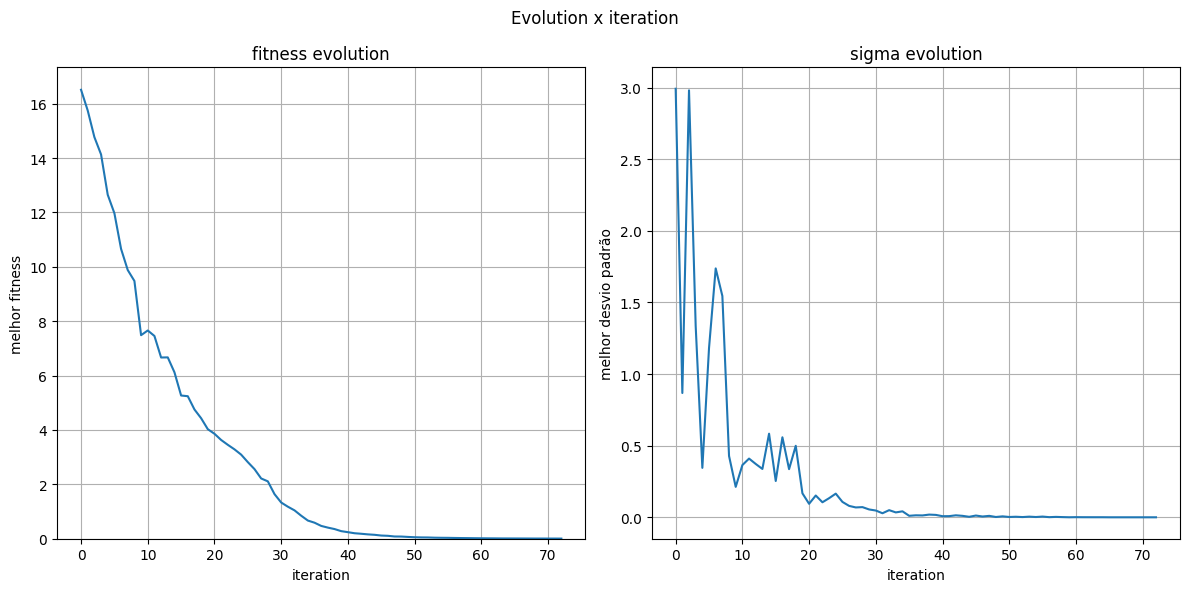

0.0047 [-0.0005, -0.0, 0.0006, -0.0002, 0.0022, 0.0008, 0.0, -0.0, 0.0006, 0.0032, -0.0013, 0.0012, -0.002, 0.0004, -0.0009, -0.0001, -0.0001, -0.0027, -0.0015, -0.0008, 0.0004, -0.0018, 0.0003, -0.0004, 0.0001, 0.0013, 0.0004, -0.0005, -0.0004, 0.0003]
Média: 4.2673
Desvio Padrão: 1.3053568165391858
Execuções com sucesso: 1 de 50


In [80]:
FITNESS_FUNC = ackley_funct
CROSSOVER_FUNC = local_discrete
SURV_SELECTION_FUNC = generational

run_executions()

 4.0761 101  4.0298 104  5.3194 96  5.6780 100  6.3040 98  4.7378 100  4.4242 99  3.7854 102  3.0270 106  5.7625 99  5.1584 94  4.9195 99  2.0133 104  6.3990 90  3.9344 96  3.7338 101  4.1219 101  3.7855 98  3.5186 99  4.6623 98  5.2877 99  4.4654 98  4.6623 98  6.5818 100  4.5849 98  6.4687 96  4.7001 99  5.9519 96  6.0044 95  2.6609 104  5.2235 97  4.8839 95  5.5329 106  5.7345 98  6.0814 96  3.5187 100  4.4653 98  4.9546 93  5.6780 93  5.0581 98  4.9890 96  5.9255 99  3.0938 100  4.8839 102  3.5183 103  4.5850 100  5.1911 97  4.3409 98  3.0929 111  5.3506 98 

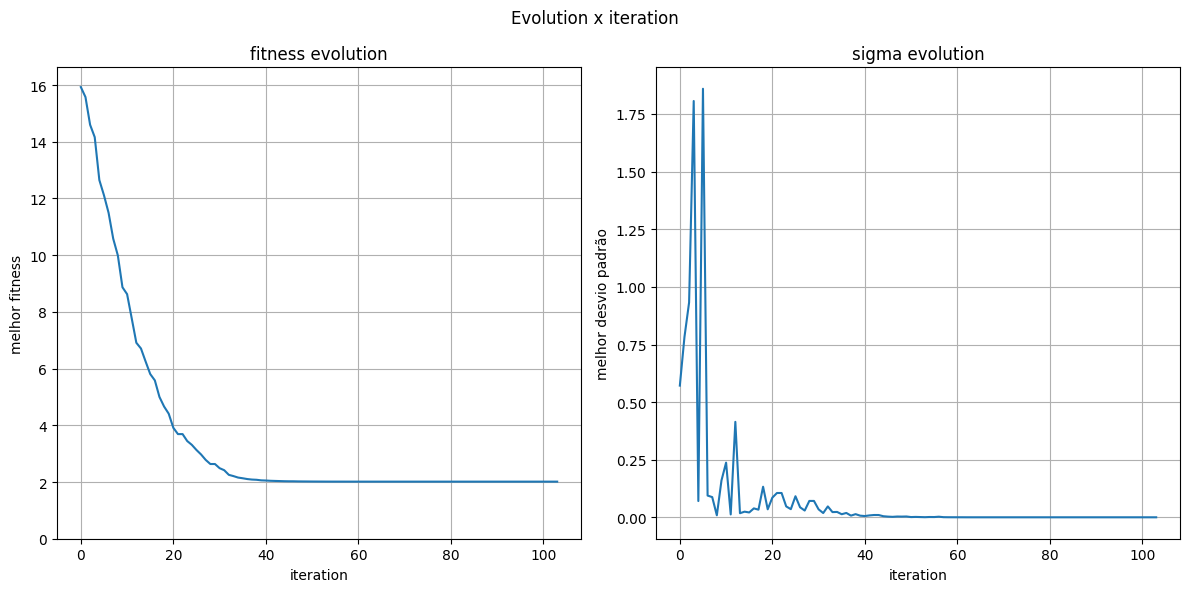

2.0133 [0.0003, -0.0001, -0.9357, -0.0002, 0.934, 0.9359, -0.0002, 0.0002, -0.9353, 0.0003, 0.9352, -0.0011, -0.933, -0.9361, 0.0005, 0.0003, 0.0007, 0.9352, 0.0002, 0.0, -0.9355, 0.0001, 0.0006, -0.0008, -0.0001, 0.0006, -0.0015, -0.0004, 0.0001, -0.0016]
Média: 4.7372
Desvio Padrão: 1.0397238157693056
Execuções com sucesso: 0 de 50


In [81]:
FITNESS_FUNC = ackley_funct
CROSSOVER_FUNC = local_discrete
SURV_SELECTION_FUNC = elitist

run_executions()

 0.9324 99  1.7780 99  1.3405 106  1.5018 120  1.6463 117  4.9547 92  2.3169 103  1.1552 127  1.6462 110  1.6462 108  0.0049 122  1.5018 103  0.9313 101  0.0043 65  3.2225 103  1.1552 115  1.3405 104  1.8998 107  0.9313 93  1.1552 112  2.8872 97  0.0049 92  1.1552 109  1.1552 99  1.5018 118  1.7780 101  4.1221 92  1.6462 103  1.5018 112  0.0045 124  1.7780 96  0.0048 70  0.0048 66  0.9318 104  1.1552 105  1.1552 108  0.9313 113  0.9313 97  0.0048 115  1.7780 107  0.9313 143  1.5018 100  1.3405 105  0.0045 133  1.8998 94  0.9313 103  0.0047 93  1.3404 133  2.4959 104  2.2210 91 

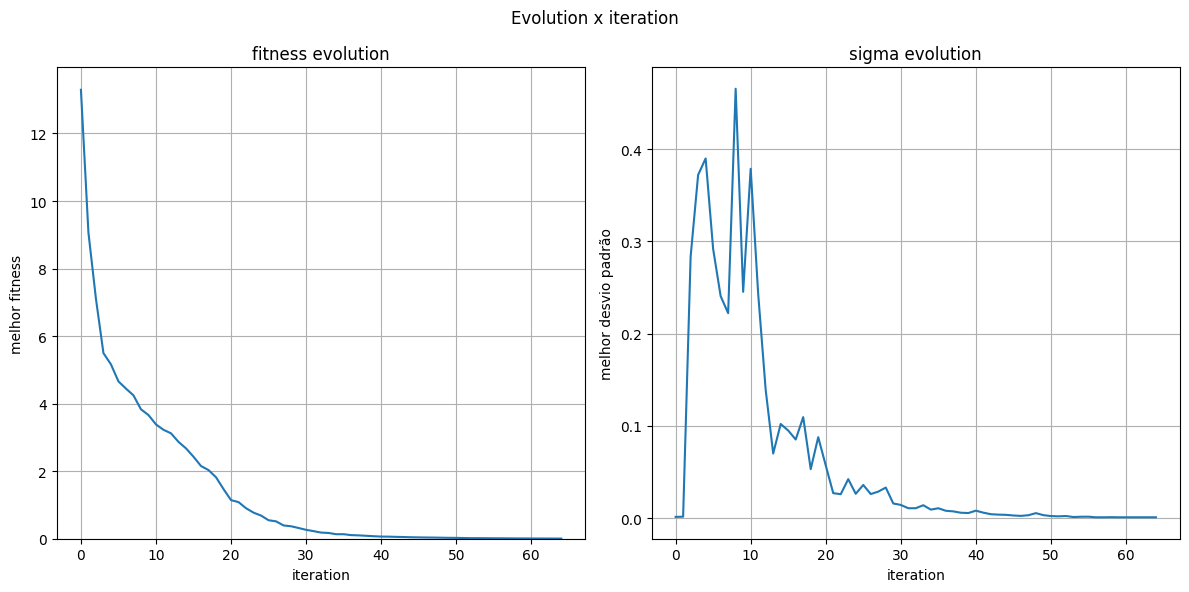

0.0043 [0.0006, -0.0015, -0.0003, -0.0018, 0.0011, -0.0, 0.0022, -0.002, 0.0006, -0.0008, 0.0005, -0.001, 0.0001, 0.001, -0.0005, 0.0005, -0.0008, 0.0012, -0.0007, 0.0007, 0.0003, -0.0006, 0.001, -0.001, 0.0001, 0.0009, 0.0009, -0.001, 0.0025, -0.0005]
Média: 1.3634
Desvio Padrão: 0.9930195970399484
Execuções com sucesso: 9 de 50


In [82]:
FITNESS_FUNC = ackley_funct
CROSSOVER_FUNC = local_intermediary
SURV_SELECTION_FUNC = generational

run_executions()

 1.1552 110  1.5018 105  0.0048 64  0.9313 112  4.2551 87  2.2210 95  3.1591 94  3.0268 97  1.8998 108  1.8998 101  1.1552 108  2.4083 115  0.0047 92  0.0046 98  0.9319 103  0.0048 72  1.3404 129  1.8998 98  1.1552 164  0.0046 84  2.2210 107  0.0048 114  1.5018 97  1.8998 103  1.1552 106  0.0050 130  1.5018 109  1.3404 112  0.0047 75  1.8998 98  1.1552 108  2.0133 101  0.0048 74  0.9313 108  0.0050 138  1.3404 121  1.6462 102  1.5018 103  2.2210 106  2.1201 109  1.3404 105  0.0045 69  1.5018 107  2.0133 118  2.1201 97  2.0133 102  1.6462 130  1.7780 106  1.8998 111  1.8998 94 

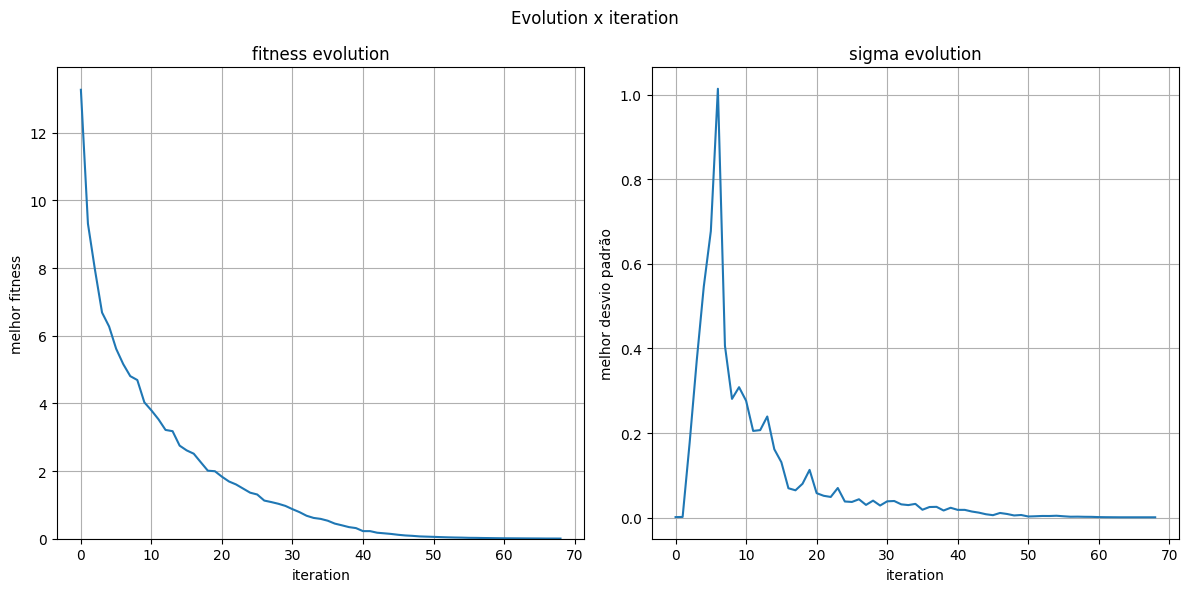

0.0045 [-0.0015, 0.0011, -0.0006, 0.0005, 0.0004, -0.0004, -0.0001, 0.0001, 0.0014, 0.0, 0.0004, 0.0001, 0.0003, 0.0008, 0.0005, 0.0015, 0.0026, -0.0006, -0.002, -0.0014, -0.0001, -0.0011, -0.0006, 0.0023, -0.0001, -0.0005, 0.0, -0.0012, -0.0023, 0.0]
Média: 1.3931
Desvio Padrão: 0.9332252900866663
Execuções com sucesso: 11 de 50


In [83]:
FITNESS_FUNC = ackley_funct
CROSSOVER_FUNC = local_intermediary
SURV_SELECTION_FUNC = elitist

run_executions()

### Resultados com função de SCHWEFEL

In [89]:
RANGE_XI=(-500,500)
EPSILON_1 = 333

 592.1921 135  1519.9617 124  947.5071 123  769.8604 135  692.4105 130  1263.3481 137  927.7701 126  710.6304 129  1166.1638 131  947.5071 122  1184.3837 119  1717.3644 126  1144.9097 129  1006.7371 126  710.6304 122  889.8158 143  829.0905 134  1185.9008 135  1164.6467 126  473.7537 131  1677.8904 132  1204.1398 132  1243.6138 127  1006.7371 136  1125.1754 132  1184.3837 128  1105.4384 125  592.1921 128  1717.3644 128  1441.1083 119  769.8604 127  769.8604 132  1065.9783 128  1441.0164 137  809.3317 124  1559.4548 123  789.5947 125  927.7701 123  454.0167 135  1936.0238 125  690.8934 130  1598.9505 130  1756.8713 124  829.0687 117  809.3317 130  1598.9261 132  592.1921 124  927.7701 120  1519.9835 129  1046.2084 117 

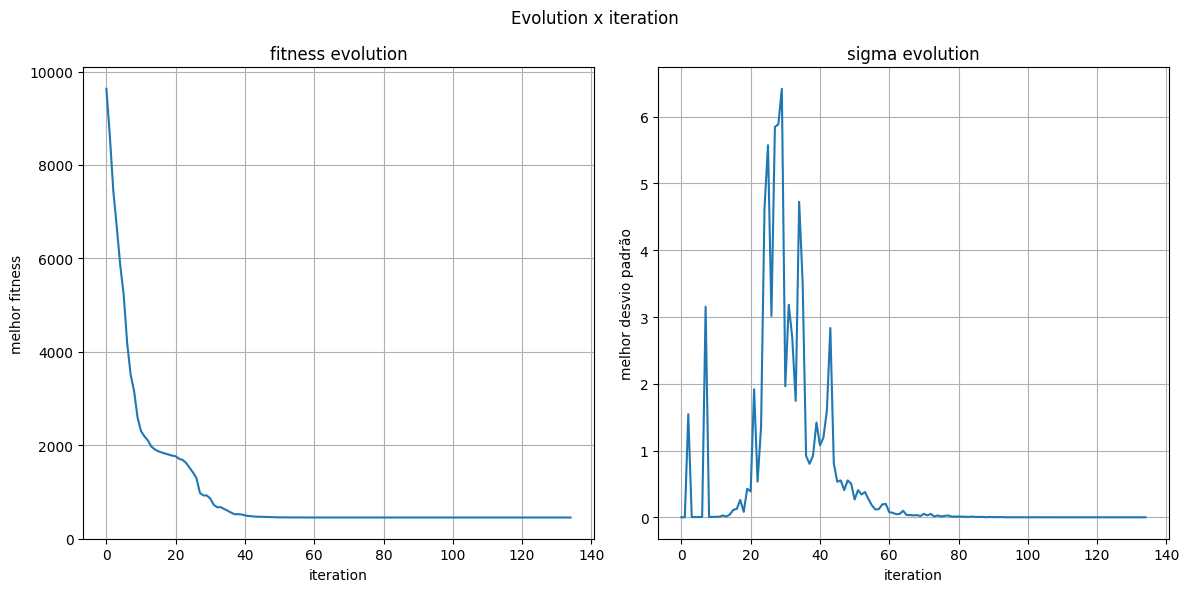

454.0167 [420.9686, 420.9684, 420.9695, -302.5249, 420.9672, 420.9689, 420.9687, 420.9679, 420.9699, 420.9677, 203.8134, 420.9697, 420.9692, 420.9691, 420.9681, 420.9706, 420.9684, 420.9683, -302.5252, 420.9688, 420.9681, 420.9681, 420.9682, 420.9687, 420.9664, 420.9673, 420.9664, 420.9692, 420.9689, 420.9692]
Média: 1080.7146
Desvio Padrão: 367.5177520843116
Execuções com sucesso: 0 de 50


In [90]:
FITNESS_FUNC = schwefel_funct
CROSSOVER_FUNC = local_discrete
SURV_SELECTION_FUNC = generational

run_executions()

 454.0167 129  829.0687 128  710.6304 122  809.3317 129  1973.9998 124  1500.2247 117  2013.5630 128  1067.4625 140  809.3317 133  947.5071 129  1046.2084 126  1618.6631 114  1105.4384 131  2013.5040 131  1638.4001 123  1816.0684 132  1125.1754 123  592.1921 125  927.7701 129  1223.8768 120  710.6304 129  1342.3151 131  592.1921 127  1283.0851 127  1046.2084 133  1677.8931 123  1263.3481 131  1401.5563 127  1934.5041 124  710.6304 118  1638.4001 131  1559.4548 133  1559.4548 126  1065.9454 129  710.6304 114  2136.5341 2156  1223.8768 119  1579.1918 125  987.0001 121  592.1921 118  1046.2084 127  1756.9520 119  2033.2081 126  1462.2705 129  1460.7534 117  592.1921 126  829.0687 125  1579.1918 136  1085.7014 119  750.1234 121 

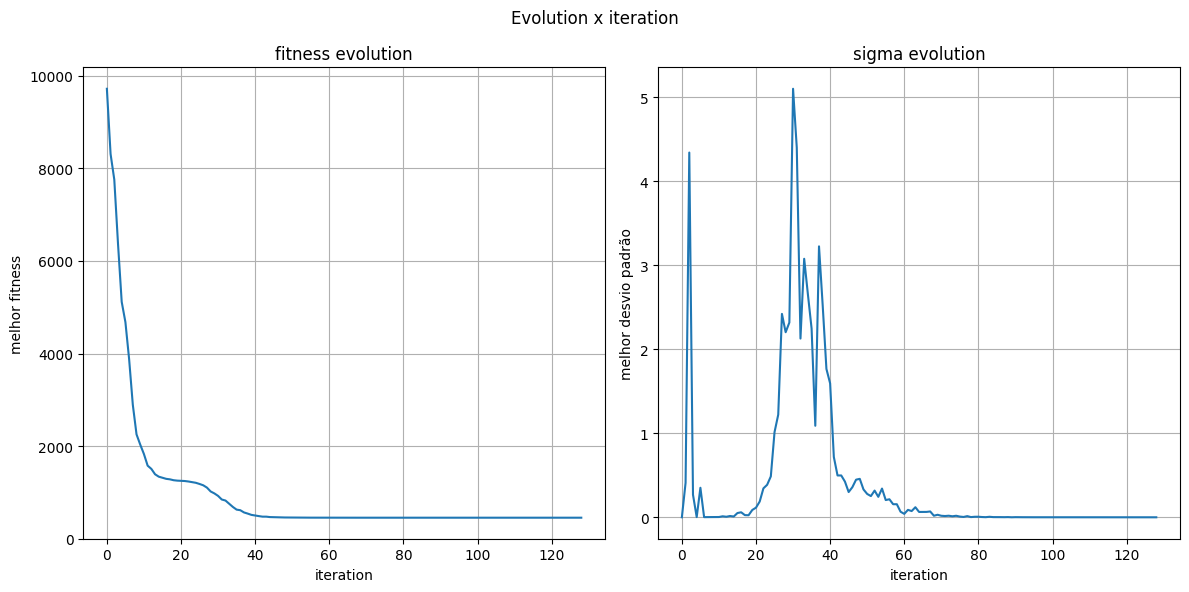

454.0167 [420.97, 420.9699, 420.9687, 420.9694, 420.9692, 420.9682, 203.8126, 420.9686, 420.9688, 420.9699, -302.5246, 420.9694, -302.5259, 420.9683, 420.9679, 420.9676, 420.969, 420.9709, 420.9686, 420.9683, 420.9692, 420.9696, 420.9694, 420.9674, 420.9693, 420.9684, 420.9681, 420.9687, 420.9686, 420.9698]
Média: 1236.6629
Desvio Padrão: 455.6813486167882
Execuções com sucesso: 0 de 50


In [91]:
FITNESS_FUNC = schwefel_funct
CROSSOVER_FUNC = local_discrete
SURV_SELECTION_FUNC = elitist

run_executions()

 9892.2958 128  6929.2153 125  8093.8339 140  9377.8355 127  8035.2166 146  9989.4696 134  8175.0299 132  10405.9886 119  9496.7748 137  9002.5992 135  10386.0246 121  7186.5930 144  8430.5968 122  8667.0223 129  8410.4235 134  9338.8312 137  9418.5593 133  9081.8677 126  9417.4427 124  9496.7297 137  7541.2475 130  9003.0844 132  9654.1327 126  8430.1494 144  8687.1599 150  9063.7618 147  9772.7795 129  7936.5114 126  8569.3538 136  7463.5977 130  9359.2814 127  9180.7049 129  10281.1340 137  8983.2199 145  8568.2853 123  9358.8422 124  7996.1544 132  8331.2839 126  8153.6044 142  8845.7347 124  9258.7309 120  9852.3880 123  8450.1104 135  9457.2143 133  9358.3845 132  8390.6610 126  9240.0391 133  10327.1134 124  9812.6430 119  10446.3795 126 

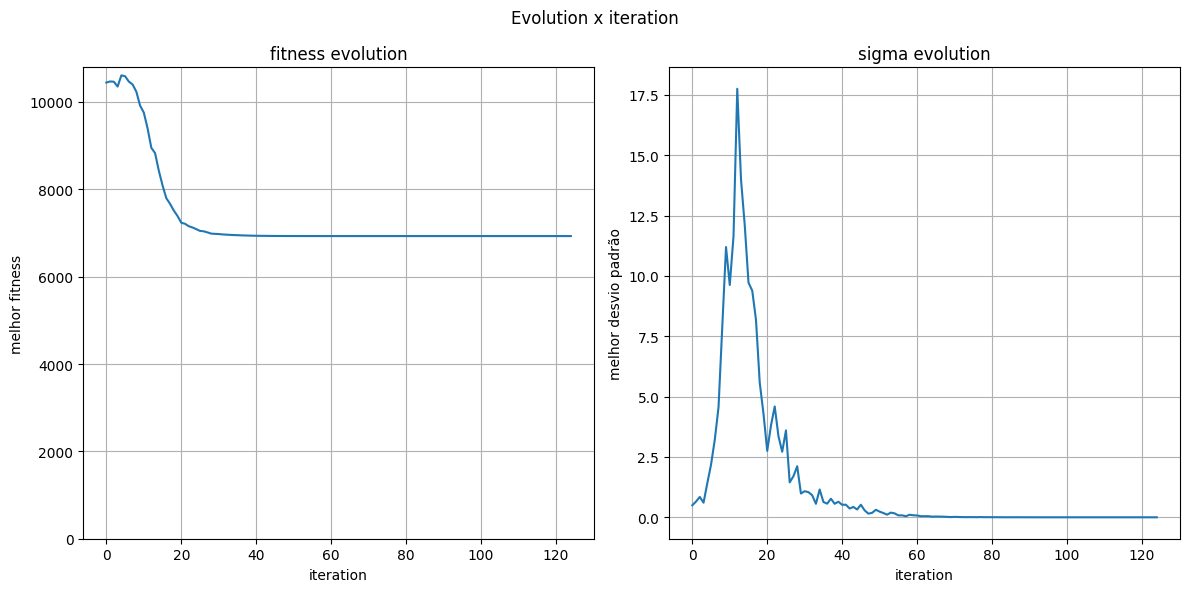

6929.2153 [65.5489, 65.5482, -302.5263, -25.8774, -124.8302, 65.5469, -124.8303, -302.5244, -302.5255, 203.8141, 420.9692, 203.814, -124.8285, 65.5484, 65.5478, -302.5252, -124.8289, 420.9692, 203.8153, 420.9684, 203.8138, 65.5485, -25.8774, 65.5497, -302.5255, 420.9686, -124.8297, 420.9682, 65.5475, 65.5475]
Média: 8980.1207
Desvio Padrão: 842.5980136350553
Execuções com sucesso: 0 de 50


In [92]:
FITNESS_FUNC = schwefel_funct
CROSSOVER_FUNC = local_intermediary
SURV_SELECTION_FUNC = generational

run_executions()

 9615.6606 124  10228.9057 126  9516.9040 137  7522.0142 139  8983.4944 140  9595.9714 140  8034.8094 136  8943.8448 166  9357.7982 120  9753.3651 144  10189.1248 128  9101.7958 121  10097.5162 125  8292.4900 124  7838.0392 127  9042.7340 130  7759.1630 136  9911.7091 125  9437.6695 124  9378.3476 145  8647.1135 122  9278.8770 135  9595.8711 123  9319.9583 130  9693.8124 128  7778.7978 145  8943.4950 136  8805.2417 121  8805.4061 124  7621.4481 151  9951.8586 123  9042.1768 131  10108.6108 125  6929.1835 148  9417.6990 126  9950.8512 120  8865.4606 131  8864.3725 152  9419.1182 135  9062.7007 137  9852.6987 123  7818.4998 134  9398.2912 135  9773.3198 125  9851.7381 134  8510.0346 127  10208.0906 126  9832.2955 122  9357.7063 122  9695.4327 146 

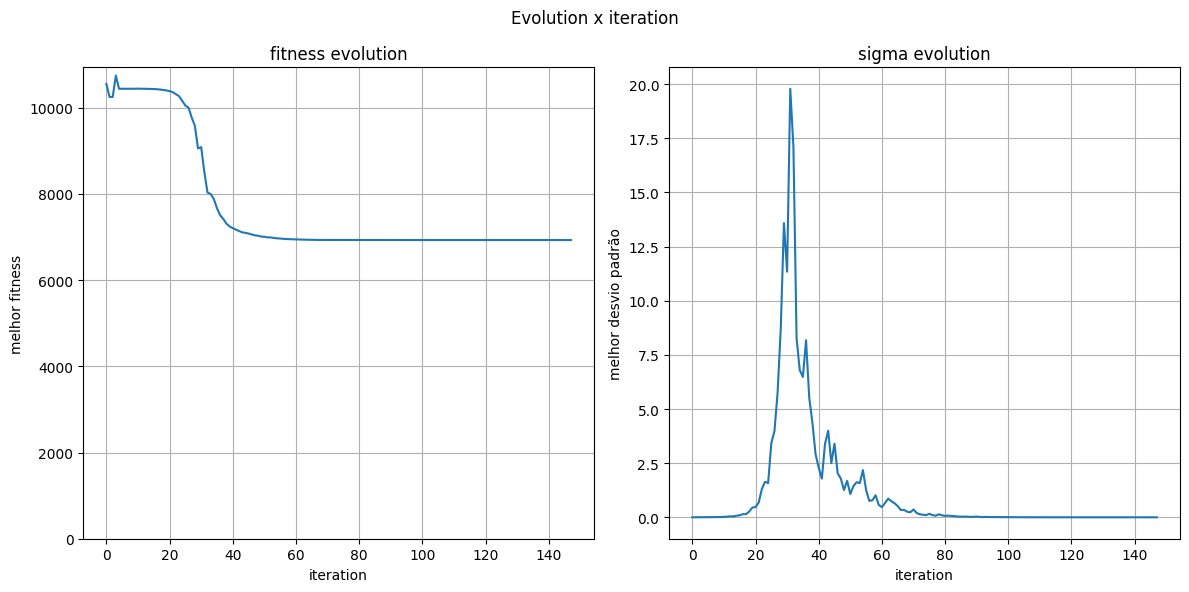

6929.1835 [-124.8292, -124.8294, -25.8763, -302.5232, -302.5259, 203.815, -302.5252, -124.8288, -124.8286, 420.9685, -25.8771, 203.8145, 65.5484, -124.829, 65.5478, -124.8291, 65.5482, 65.548, 203.8134, -302.5241, 420.9696, 203.8153, -124.8295, 203.8138, -302.5259, 203.8152, -302.5246, -25.8763, -302.5265, -302.5244]
Média: 9140.0303
Desvio Padrão: 793.3968695345021
Execuções com sucesso: 0 de 50


In [95]:
FITNESS_FUNC = schwefel_funct
CROSSOVER_FUNC = local_intermediary
SURV_SELECTION_FUNC = generational

run_executions()

### Resultados com função de SUM SQUARES

In [96]:
RANGE_XI=(-15,15)
EPSILON_1 = 10

 0.0041 97  0.0049 276  0.0049 162  0.0048 252  0.0048 113  0.0049 149  0.0043 188  0.0047 122  0.0043 113  0.0047 420  0.0049 359  0.0049 109  0.0047 336  0.0047 96  0.0047 187  0.0048 437  0.0044 74  0.0048 167  0.0050 452  0.0049 375  0.0050 215  0.0050 421  0.0049 253  0.0048 176  0.0049 443  0.0047 242  0.0048 170  0.0048 291  0.0048 479  0.0047 272  0.0049 202  0.0049 136  0.0049 145  0.0047 291  0.0046 360  0.0046 272  0.0050 255  0.0050 198  0.0049 140  0.0049 100  0.0048 190  0.0048 341  0.0047 445  0.0048 381  0.0048 395  0.0047 441  0.0047 344  0.0043 74  0.0048 106  0.0049 313 

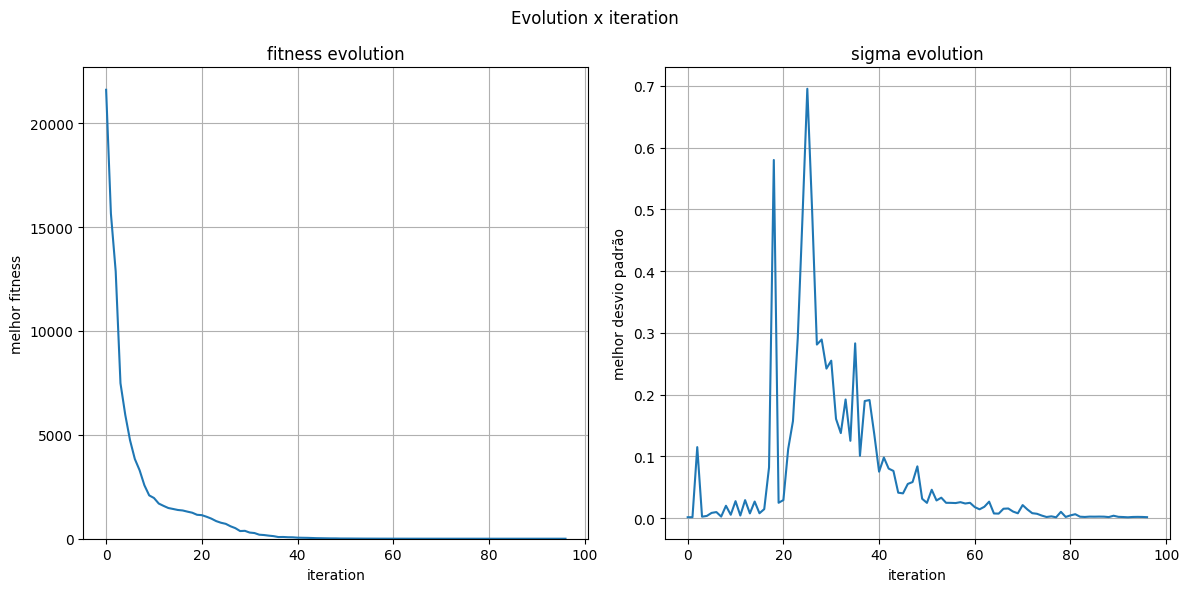

0.0041 [-0.0122, -0.0059, -0.0136, 0.0006, 0.0066, -0.0068, 0.0098, 0.0033, -0.0026, -0.005, -0.0005, -0.0005, -0.0011, -0.0006, 0.0006, -0.0038, -0.0012, 0.002, 0.0002, -0.0012, 0.0031, 0.0006, -0.0006, 0.0016, 0.0037, -0.0015, 0.0025, 0.0023, -0.0004, 0.0037]
Média: 0.0048
Desvio Padrão: 0.00018615992825394347
Execuções com sucesso: 50 de 50


In [97]:
FITNESS_FUNC = sum_squares_function
CROSSOVER_FUNC = local_discrete
SURV_SELECTION_FUNC = generational

run_executions()

 0.0050 356  0.0050 261  0.0049 201  0.0048 378  0.0049 201  0.0048 165  0.0050 238  0.0048 297  0.0047 157  0.0050 142  0.0048 489  0.0047 349  0.0049 399  0.0047 87  0.0042 80  0.0048 162  0.0050 99  0.0049 373  0.0049 150  0.0049 373  0.0050 258  0.0050 192  0.0047 258  0.0048 213  0.0050 172  0.0050 414  0.0042 72  0.0049 233  0.0047 389  0.0048 310  0.0050 146  0.0050 397  0.0049 253  0.0050 179  0.0050 163  0.0045 73  0.0047 243  0.0049 190  0.0047 267  0.0050 210  0.0050 365  0.0049 78  0.0047 318  0.0050 143  0.0050 436  0.0047 222  0.0050 305  0.0047 70  0.0048 378  0.0046 189 

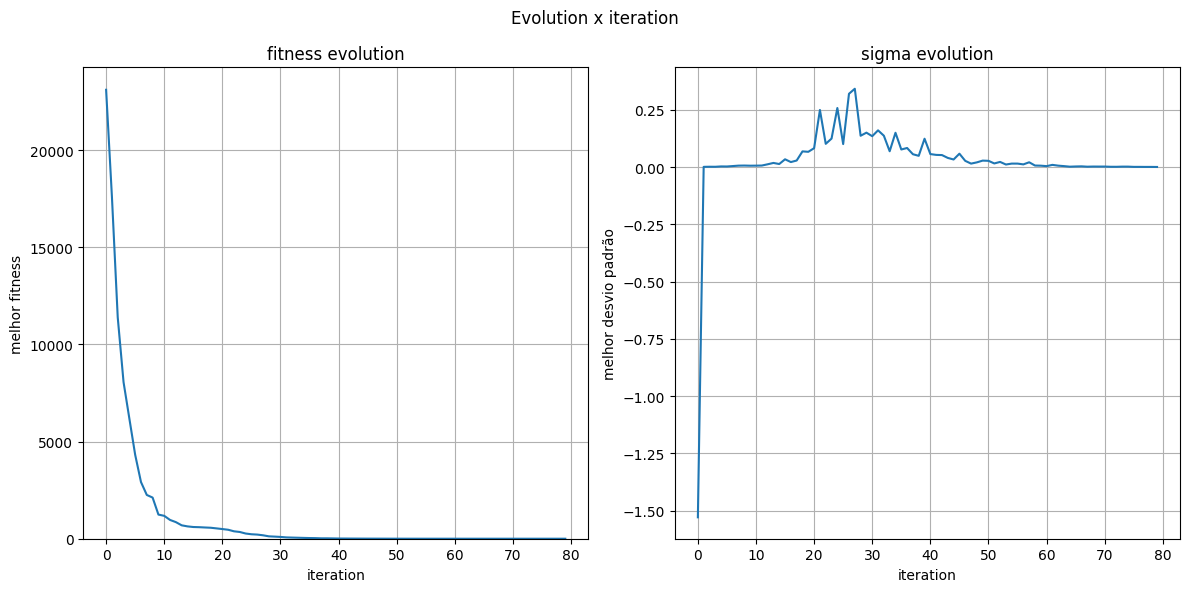

0.0042 [-0.0121, -0.0056, 0.003, 0.0218, 0.0014, -0.0007, 0.0067, -0.0016, -0.001, -0.0035, 0.0039, 0.0017, -0.0021, -0.0029, 0.0029, 0.0034, -0.0031, -0.0009, -0.0004, 0.0005, -0.0013, -0.0002, -0.001, 0.0036, -0.0015, 0.0018, 0.0016, 0.0019, 0.0007, 0.0005]
Média: 0.0048
Desvio Padrão: 0.00017530646785860897
Execuções com sucesso: 50 de 50


In [98]:
FITNESS_FUNC = sum_squares_function
CROSSOVER_FUNC = local_discrete
SURV_SELECTION_FUNC = elitist

run_executions()

 0.0048 381  0.0049 413  0.0049 173  0.0049 482  0.0048 408  0.0050 438  0.0049 369  0.0049 535  0.0050 292  0.0049 279  0.0049 389  0.0049 334  0.0050 569  0.0050 377  0.0048 493  0.0049 460  0.0049 520  0.0047 517  0.0049 462  0.0050 515  0.0049 189  0.0047 499  0.0047 632  0.0050 210  0.0050 496  0.0050 386  0.0049 344  0.0049 198  0.0049 481  0.0049 436  0.0049 291  0.0048 482  0.0050 581  0.0049 479  0.0050 455  0.0050 203  0.0047 258  0.0048 260  0.0050 386  0.0050 248  0.0046 263  0.0049 504  0.0048 407  0.0049 559  0.0048 445  0.0049 313  0.0049 581  0.0050 482  0.0048 297  0.0049 320 

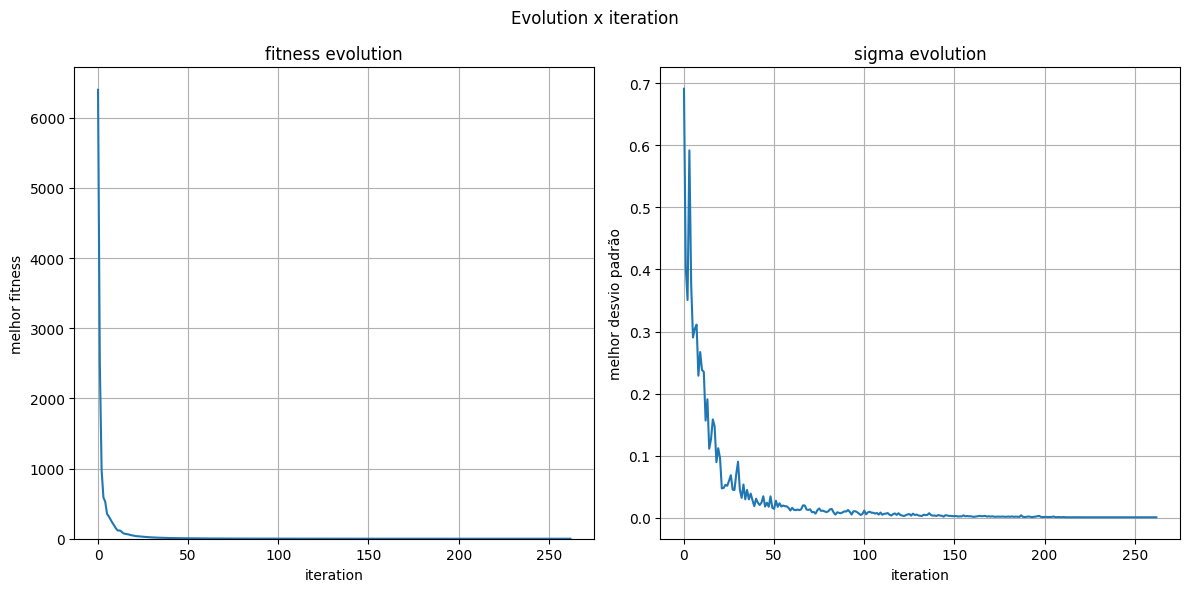

0.0046 [-0.0352, -0.0376, -0.0084, 0.0009, -0.0003, 0.001, -0.0008, -0.0009, 0.0006, -0.0017, 0.0009, -0.0011, 0.001, 0.0009, 0.0003, -0.0009, -0.0015, -0.0002, -0.0011, 0.0005, -0.0006, -0.0018, 0.0002, -0.0002, 0.0, 0.0003, -0.0002, -0.0001, 0.0014, -0.0008]
Média: 0.0049
Desvio Padrão: 8.505421071645628e-05
Execuções com sucesso: 50 de 50


In [99]:
FITNESS_FUNC = sum_squares_function
CROSSOVER_FUNC = local_intermediary
SURV_SELECTION_FUNC = generational

run_executions()

 0.0048 447  0.0047 412  0.0048 342  0.0047 273  0.0049 340  0.0048 258  0.0048 528  0.0048 463  0.0049 534  0.0049 505  0.0049 577  0.0048 489  0.0049 333  0.0050 506  0.0049 511  0.0050 500  0.0050 362  0.0048 553  0.0048 250  0.0049 211  0.0050 298  0.0048 441  0.0046 477  0.0049 504  0.0049 603  0.0049 420  0.0049 504  0.0049 476  0.0049 212  0.0049 505  0.0049 154  0.0049 294  0.0047 439  0.0049 483  0.0049 431  0.0050 533  0.0049 311  0.0049 303  0.0049 401  0.0049 289  0.0050 546  0.0049 516  0.0048 403  0.0049 450  0.0048 377  0.0049 271  0.0048 472  0.0050 329  0.0049 360  0.0049 340 

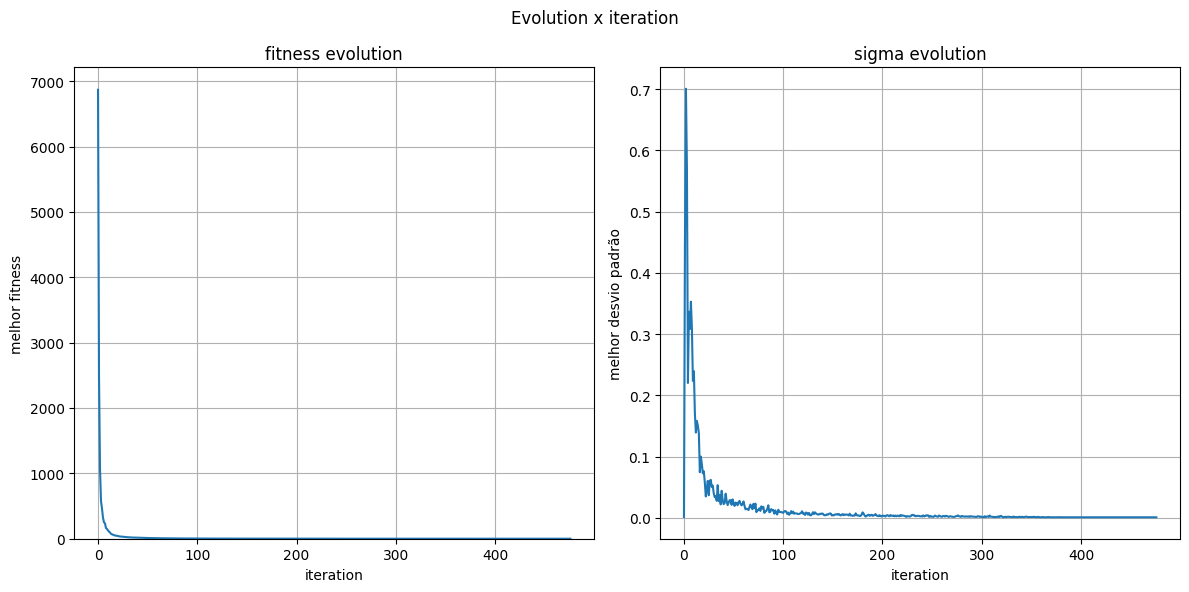

0.0046 [0.0657, 0.0013, -0.0024, -0.0014, -0.0015, 0.0016, 0.0006, -0.0022, 0.0003, -0.0012, -0.0, 0.0009, 0.0, 0.0001, -0.0003, 0.0004, 0.0, -0.0007, -0.0004, 0.0005, 0.0002, -0.0007, -0.0007, 0.001, 0.0007, -0.0008, -0.0011, 0.0004, -0.0, -0.0013]
Média: 0.0049
Desvio Padrão: 7.931578489067552e-05
Execuções com sucesso: 50 de 50


In [100]:
FITNESS_FUNC = sum_squares_function
CROSSOVER_FUNC = local_intermediary
SURV_SELECTION_FUNC = elitist

run_executions()

# Estratégia Genética

In [6]:
PROB_RECOMBINACAO = 0.9
PROB_MUTACAO = 0.4

TAM_POPULACAO = 100

ITERACOES = 10_000 # similar: épocas

TAM_GENOTIPO = D
PONTO_CORTE_CROSSOVER = 11

RANGE_XI = (-15,15)

populacao = [] # será preenchido depois

### Gerar indivíduos

In [7]:
def generate_individual():
  x = []
  for i in range(D):
    x.append(random.uniform(RANGE_XI[0], RANGE_XI[1]))
    
  return x

### Criar e resetar população

In [8]:
def criar_populacao() -> None:
  """ Cria a população de acordo com o valor dado em 'TAM_POPULACAO' """

  global populacao

  for i in range(TAM_POPULACAO):
    populacao.append(generate_individual())

def resetar_populacao() -> None:
  """ Reseta a população """
  global populacao

  populacao = []

### Selecionar pais

In [9]:
def selecionar_pais_roleta():
    """ Dá uma chance para cada indivíduo da população, proporcional ao seu fitness, e realiza um sorteio de 2 pais.' 
    :return: Tupla com os dois pais
    """

    global populacao, FITNESS_FUNC

    soma_fitness = sum([fitness(FITNESS_FUNC, elem) for elem in populacao]) # somar fitness originais

    pais = []

    for _ in range(2):
      populacao_com_novos_fitness = [] 
      nova_soma_fitness = 0

      for elem in populacao:
        fitness_ = fitness(FITNESS_FUNC, elem)

        if fitness_ == 0: # caso exista uma solução, ela será retornada, já que não é possível calcular roleta
          return elem, elem
          
        fitness_ = soma_fitness / fitness_
        populacao_com_novos_fitness.append(fitness_)
        nova_soma_fitness += fitness_

      probabilidades_na_roleta = []
      last_fitness = 0
      for fitness_ in populacao_com_novos_fitness:
        probabilidades_na_roleta.append(last_fitness + fitness_/nova_soma_fitness) 

      roleta_girada = random.uniform(0, 1) # girar roleta
      pai = None 

      for i in range(len(probabilidades_na_roleta)):
        if i > 0:
          probabilidades_na_roleta[i] =  probabilidades_na_roleta[i] + probabilidades_na_roleta[i-1]

        if roleta_girada < probabilidades_na_roleta[i] :
          if i == 0:
            pai = populacao[0]
          else:
            pai = populacao[i-1]

          break

      pais.append(pai)

    return pais[0], pais[1]

### Crossover

In [10]:
def crossover(pai1, pai2):
  """ Crossover 'cut-and-crossfill'.
  :param pai1: primeiro individuo
  :param pai2: segundo individuo
  :return: Tupla com os dois filhos gerados
  """

  filho1 = aux_cut_and_crossfill(pai1, pai2)
  filho2 = aux_cut_and_crossfill(pai2, pai1)

  return filho1, filho2

def aux_cut_and_crossfill(pai1, pai2):
  """ Funçao auxiliar do 'cut-and-crossfill'.
  :param pai1: pai que vai passar a primeira metade do ponto de corte
  :param pai2: outro pai
  :return: o filho no formato de lista de int, onde cada int representa um gene
  """

  filho = pai1[:PONTO_CORTE_CROSSOVER]
  for elem in pai2[PONTO_CORTE_CROSSOVER:] + pai2[:PONTO_CORTE_CROSSOVER]:
    if len(filho) == TAM_GENOTIPO: break

    filho.append(elem)

  return filho

In [11]:
def verificar_se_crossover() -> bool:
  """ Verifica se um crossover deve acontecer de acordo com a probabilidade dada por 'PROB_RECOMBINACAO'.
  :return: booleano indicando caso crossover deva ser realizado. """
  
  return random.uniform(0, 1) <= PROB_RECOMBINACAO

In [12]:
def tentar_crossover(pai1, pai2, crossover_function: Callable):
  """ Tenta realizar o crossover a partir dos pais e da função de crossover dada.
  :param pai1: Primeiro individuo
  :param pai2: Segundo individuo
  :param crossover_function: Função de crossover que deve ser utilizado
  :return: Dois novos filhos. Caso não haja crossover, os dois pais são retornados.
  """

  if verificar_se_crossover():
    return crossover_function(pai1, pai2)
  
  return pai1, pai2

### Mutação

In [13]:
def mutacao_por_perturbacao(individuo: List[float]) -> List[float]:
    """ Realiza mutação 'por perturbação' 
    :param individuo: Individuo no qual será realizada a mutação.
    :return: Individuo mutado.
    """

    indices = random.sample(range(D), D // 3)
    valores = [individuo[indice] for indice in indices]
    valores_permutados = np.random.permutation(valores)

    for i in range(len(valores_permutados)):
      individuo[indices[i]] = valores_permutados[i]

    return individuo

In [14]:
def verificar_se_mutacao() -> bool:
  """ Verifica se uma mutação deve acontecer de acordo com a probabilidade dada por 'PROB_MUTACAO'.
  :return: booleano indicando caso mutação deva ser realizada. """

  return random.uniform(0, 1) <= PROB_MUTACAO

In [15]:
def tentar_mutacao(individuo, mutacao_function: Callable):
  """ Tenta realizar uma mutação a partir de um individuo e da função de mutação dada.
  :param individuo: Individuo a ser mutado
  :param mutacao_function: Função de mutação que deve ser utilizada
  :return: Individuo mutado. Caso não haja mutação o mesmo individuo é retornado.
  """

  if verificar_se_mutacao():
    return mutacao_function(individuo)

  return individuo

### Seleção de sobreviventes

In [16]:
def selecao_elitista():
    global populacao

    populacao.sort(key=lambda elem: fitness(FITNESS_FUNC, elem), reverse=False) 
    populacao = populacao[:TAM_DA_POPULACAO]

### Rodar solução

In [17]:
def plot_results(best_fitness, best_solution, bests_fitness, iterations, num_exec_com_sucesso) -> None:
    fig = plt.figure(figsize=(12, 6))
    
    ax1 = fig.add_subplot(121)
    fig.suptitle('Evolution')
    
    # Fitness
    ax1.plot(range(0, iterations), bests_fitness)
    ax1.set(xlabel='iteration', ylabel='melhor fitness',ylim = 0,
           title='fitness evolution')
    ax1.grid()

    fig.tight_layout()
    plt.show()

    print(f'{best_fitness:.4f}', [round(sol, 4) for sol in best_solution])

    print("Média:", f'{np.mean(bests_fitness):.4f}')
    print("Desvio Padrão:", np.std(bests_fitness))
    print("Execuções com sucesso:", num_exec_com_sucesso, "de", NUM_EXEC)

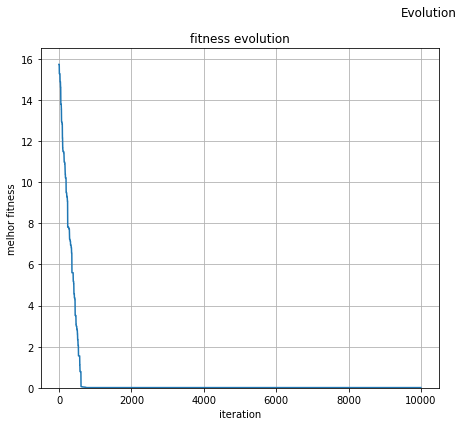

0.0101 [-0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024, -0.0024]
Média: 0.4589
Desvio Padrão: 2.0555950401156844
Execuções com sucesso: 0 de 30


In [33]:
convergiram = 0
best_fitness = float("inf")
best_sol = []
fitness_best_sol = []
best_sol_iterations = 0

for _ in range(NUM_EXEC):
  resetar_populacao()
  criar_populacao()

  list_fitness = []

  FITNESS_FUNC = ackley_funct

  for i in range(ITERACOES):
      pai1, pai2 = selecionar_pais_roleta()

      filho1, filho2 = tentar_crossover(pai1, pai2, crossover)
      filho1, filho2 = tentar_mutacao(filho1, mutacao_por_perturbacao), tentar_mutacao(filho2, mutacao_por_perturbacao)
      populacao.append(filho1)
      populacao.append(filho2)

      selecao_elitista()

      fitness_ = fitness(FITNESS_FUNC, populacao[0])

      list_fitness.append(fitness_)
      
      if is_close(fitness_, 0):
        print("Solução:", populacao[0])
        print(f'Quantidade de épocas levadas: {i+1}')
        print(f'Fitness médio: {np.mean([fitness(FITNESS_FUNC, elem) for elem in populacao]) : .2f}')

        if fitness(FITNESS_FUNC, populacao[1]) == 0:
          print(f'Num de indivíduos que convergiram: {2}')
        else:
          print(f'Num de indivíduos que convergiram: {1}')

        print("Genótipos próximos: ")
        for ind in populacao[:10]:
          print(ind)
        break

  if i + 1 != ITERACOES:
    convergiram += 1

  if fitness_ < best_fitness:
    best_fitness = fitness(FITNESS_FUNC, populacao[0])
    best_sol = populacao[0]
    fitness_best_sol = list_fitness
    best_sol_iterations = i + 1

plot_results(best_fitness, best_sol, fitness_best_sol, best_sol_iterations, convergiram)

### Versão 2

In [34]:
def mutacao_por_offset(individuo: List[float]) -> List[float]:
    """ Realiza mutação 'por offset' de `D/3` genes utilizando N(0,7)
    :param individuo: Individuo no qual será realizada a mutação.
    :return: Individuo mutado.
    """

    indices = random.sample(range(D), D // 3)

    for i in range(len(indices)):
      individuo[indices[i]] = individuo[indices[i]] + random.normalvariate(0, 7)
      individuo[indices[i]] = max(RANGE_XI[0], individuo[indices[i]])
      individuo[indices[i]] = min(RANGE_XI[1], individuo[indices[i]])

    return individuo

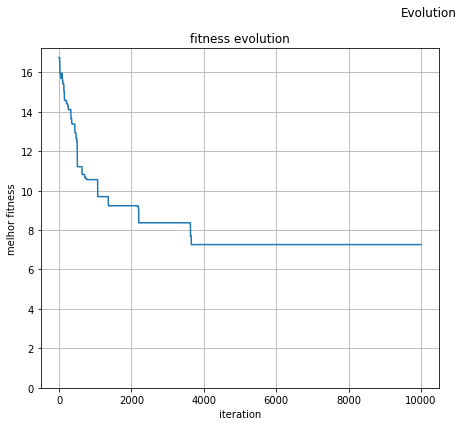

7.2611 [-2.0668, -3.017, -1.3443, -1.5725, -1.9864, 1.1225, -0.7886, -0.3135, 0.5851, 2.881, -1.2487, -0.1514, -2.4015, 1.179, -2.7129, 1.9584, 2.0293, -0.1618, 1.3891, -1.2324, 0.5408, 2.122, -0.7901, -0.2273, 1.4358, -0.5354, -2.0752, -1.2535, -3.1045, -1.1187]
Média: 8.2099
Desvio Padrão: 1.7460835001474513
Execuções com sucesso: 0 de 30


In [35]:
convergiram = 0
best_fitness = float("inf")
best_sol = []
fitness_best_sol = []
best_sol_iterations = 0

for _ in range(NUM_EXEC):
  resetar_populacao()
  criar_populacao()

  list_fitness = []

  FITNESS_FUNC = ackley_funct

  for i in range(ITERACOES):
      pai1, pai2 = selecionar_pais_roleta()

      filho1, filho2 = tentar_crossover(pai1, pai2, crossover)
      filho1, filho2 = tentar_mutacao(filho1, mutacao_por_modificacao), tentar_mutacao(filho2, mutacao_por_modificacao)
      populacao.append(filho1)
      populacao.append(filho2)

      selecao_elitista()

      fitness_ = fitness(FITNESS_FUNC, populacao[0])

      list_fitness.append(fitness_)
      
      if is_close(fitness_, 0):
        print("Solução:", populacao[0])
        print(f'Quantidade de épocas levadas: {i+1}')
        print(f'Fitness médio: {np.mean([fitness(FITNESS_FUNC, elem) for elem in populacao]) : .2f}')

        if fitness(FITNESS_FUNC, populacao[1]) == 0:
          print(f'Num de indivíduos que convergiram: {2}')
        else:
          print(f'Num de indivíduos que convergiram: {1}')

        print("Genótipos próximos: ")
        for ind in populacao[:10]:
          print(ind)
        break

  if i + 1 != ITERACOES:
    convergiram += 1

  if fitness_ < best_fitness:
    best_fitness = fitness(FITNESS_FUNC, populacao[0])
    best_sol = populacao[0]
    fitness_best_sol = list_fitness
    best_sol_iterations = i + 1

plot_results(best_fitness, best_sol, fitness_best_sol, best_sol_iterations, convergiram)

### Versão 3

In [18]:
def mutacao_por_offset2(individuo: List[float]) -> List[float]:
    """ Realiza mutação 'por offset' de `D/3` genes utilizando N(0,1)
    :param individuo: Individuo no qual será realizada a mutação.
    :return: Individuo mutado.
    """

    indices = random.sample(range(D), D // 3)

    for i in range(len(indices)):
      individuo[indices[i]] = individuo[indices[i]] + random.normalvariate(0, 1)
      individuo[indices[i]] = max(RANGE_XI[0], individuo[indices[i]])
      individuo[indices[i]] = min(RANGE_XI[1], individuo[indices[i]])

    return individuo

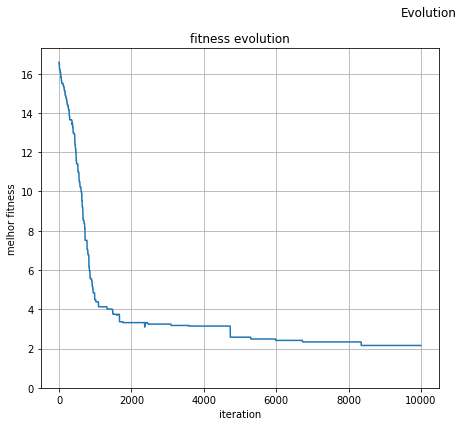

2.1562 [-0.0351, -0.2067, 0.171, 0.1726, 0.023, -0.1187, -0.0933, 0.3251, 0.0149, 0.2373, 0.1786, -0.3293, -0.0422, 0.1396, -0.1535, -0.0289, 0.0186, 0.8816, -0.0561, 0.0393, 0.1206, 0.8741, -0.9176, 0.1385, 0.2358, 0.235, 0.2061, -0.1967, 0.0291, -0.0678]
Média: 3.5802
Desvio Padrão: 2.7746496789325463
Execuções com sucesso: 0 de 30


In [21]:
convergiram = 0
best_fitness = float("inf")
best_sol = []
fitness_best_sol = []
best_sol_iterations = 0

for _ in range(NUM_EXEC):
  resetar_populacao()
  criar_populacao()

  list_fitness = []

  FITNESS_FUNC = ackley_funct

  for i in range(ITERACOES):
      pai1, pai2 = selecionar_pais_roleta()

      filho1, filho2 = tentar_crossover(pai1, pai2, crossover)
      filho1, filho2 = tentar_mutacao(filho1, mutacao_por_modificacao2), tentar_mutacao(filho2, mutacao_por_modificacao2)
      populacao.append(filho1)
      populacao.append(filho2)

      selecao_elitista()

      fitness_ = fitness(FITNESS_FUNC, populacao[0])

      list_fitness.append(fitness_)
      
      if is_close(fitness_, 0):
        print("Solução:", populacao[0])
        print(f'Quantidade de épocas levadas: {i+1}')
        print(f'Fitness médio: {np.mean([fitness(FITNESS_FUNC, elem) for elem in populacao]) : .2f}')

        if fitness(FITNESS_FUNC, populacao[1]) == 0:
          print(f'Num de indivíduos que convergiram: {2}')
        else:
          print(f'Num de indivíduos que convergiram: {1}')

        print("Genótipos próximos: ")
        for ind in populacao[:10]:
          print(ind)
        break

  if i + 1 != ITERACOES:
    convergiram += 1

  if fitness_ < best_fitness:
    best_fitness = fitness(FITNESS_FUNC, populacao[0])
    best_sol = populacao[0]
    fitness_best_sol = list_fitness
    best_sol_iterations = i + 1

plot_results(best_fitness, best_sol, fitness_best_sol, best_sol_iterations, convergiram)